## Colab version of the Notebook

In [ ]:
"""
Created on Tue Sep 07 2:58:00 2021
@Author: Shuyu Qin
         Joshua Agar
"""

'\nCreated on Tue Sep 07 2:58:00 2021\n@Author: Shuyu Qin\n         Joshua Agar\n'

In [ ]:
# if running on collaboratory set = True
collaboratory = True

if collaboratory:
    from google.colab import drive
    drive.mount('/content/drive')
else: 
    print('Running on local systems, if running on collaboratory please change above')

Mounted at /content/drive


In [ ]:
if collaboratory:
    !cd /content/drive/MyDrive

In [ ]:
#cd drive/MyDrive

In [ ]:
%load_ext autoreload
%autoreload 2
# load the package for this notebook
import torch
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
import pickle
import torch.autograd as autograd
import torch.optim as optim
import matplotlib.gridspec as gridspec
import os
from IPython.core.display import Video
from torch.autograd import Variable
import h5py
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import copy
import glob as glob
from natsort import natsorted
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
import gdown
from google_drive_downloader import GoogleDriveDownloader as gdd

In [ ]:
plt.rcParams.update({'figure.max_open_warning': 0})

In [ ]:
# install zenodo-get for file generating
!pip install zenodo-get

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=3ab91e0aa703f42ca158650bd9d3dd8131d8c6c1ffe3037a725c76f55665c0d1
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
# establish a folder to save the pretrained weights and input data
os.makedirs('input_weights', exist_ok=True)

In [ ]:
cd input_weights 

/content/input_weights


In [ ]:
# generate the file for downloading from zenodo.
!zenodo_get https://doi.org/10.5281/zenodo.5529742 -w file


In [ ]:
# download the files through wget
!wget -i file

--2021-11-11 03:30:00--  https://zenodo.org/record/5529742/files/CV.CV
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2282 (2.2K) [application/octet-stream]
Saving to: ‘CV.CV’

CV.CV               100%[===================>]   2.23K  --.-KB/s    in 0s      

2021-11-11 03:30:03 (413 MB/s) - ‘CV.CV’ saved [2282/2282]

--2021-11-11 03:30:03--  https://zenodo.org/record/5529742/files/example%20loading%20data.ipynb
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 567892 (555K) [application/octet-stream]
Saving to: ‘example loading data.ipynb’

example loading dat 100%[===================>] 554.58K   515KB/s    in 1.1s    

2021-11-11 03:30:05 (515 KB/s) - ‘example loading data.ipynb’ saved [567892/567892]

--2021-11-11 03:30:05--  https://zenodo.org/record/5529742/files/README.txt
Reusing existing connection to

In [ ]:
# if have the bug fail to download the run_059,run_074, we download it individually.
!curl --cookie zenodo-cookies.txt "https://zenodo.org/record/5529742/files/run4_0059_fit.lsqfit?download=1" --output run4_0059_fit.lsqfit

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  640k  100  640k    0     0   175k      0  0:00:03  0:00:03 --:--:--  174k


In [ ]:
!curl --cookie zenodo-cookies.txt "https://zenodo.org/record/5529742/files/run4_0074_fit.lsqfit?download=1" --output run4_0074_fit.lsqfit

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  640k  100  640k    0     0   175k      0  0:00:03  0:00:03 --:--:--  175k


In [ ]:
# if failed to download some file, wee can download it mannually, just replace the file id and output number to the missing file
!curl --cookie zenodo-cookies.txt "https://zenodo.org/record/5529742/files/run4_0123_fit.lsqfit?download=1" --output run4_0123_fit.lsqfit

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  640k  100  640k    0     0   209k      0  0:00:03  0:00:03 --:--:--  209k


In [ ]:
# download the github file contains the pretrained weights
if os.path.exists("./High-Velocity-Low-Voltage-Collective-In-Plane-Switching-in-100-BaTiO3ThinFilms"):
    pass
else:
    # ferroelectric
    !git clone https://github.com/m3-learning/High-Velocity-Low-Voltage-Collective-In-Plane-Switching-in-100-BaTiO3ThinFilms.git

Cloning into 'High-Velocity-Low-Voltage-Collective-In-Plane-Switching-in-100-BaTiO3ThinFilms'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


In [ ]:
# load the data to the input_data and make it into numpy array format.
input_data=[]
for i in range(2,131):
    # load frame
    fnum=i
    fnumstr=str(fnum)
    while len(fnumstr)<3:
        fnumstr='0'+fnumstr
    fname='./run4_0'+fnumstr+'_fit.lsqfit'
    hybrid_fit=pickle.load( open(fname, "rb" ) )

    # prep frame
    phase=hybrid_fit['phase'][0:79]*np.pi*2
    avg_phase=np.average(phase%np.pi)
    frame=hybrid_fit['amplitude'][0:79]*np.cos(phase-avg_phase)
    frame_ = frame[:,30:235]
    input_data.append(frame_)


In [ ]:
input_1 = np.array(input_data)

In [ ]:
# extract the mean and standard deviation for each image
mn_2 = np.mean(input_1,axis = 1)
sd_2 = np.std(input_1,axis = 1)
mn_2 = np.atleast_3d(mn_2)
mn_2 = np.transpose(mn_2,(0,2,1))
sd_2 = np.atleast_3d(sd_2)
sd_2 = np.transpose(sd_2,(0,2,1))

In [ ]:
# Standard scale transformation for each image
input_2 = (input_1-mn_2)/sd_2

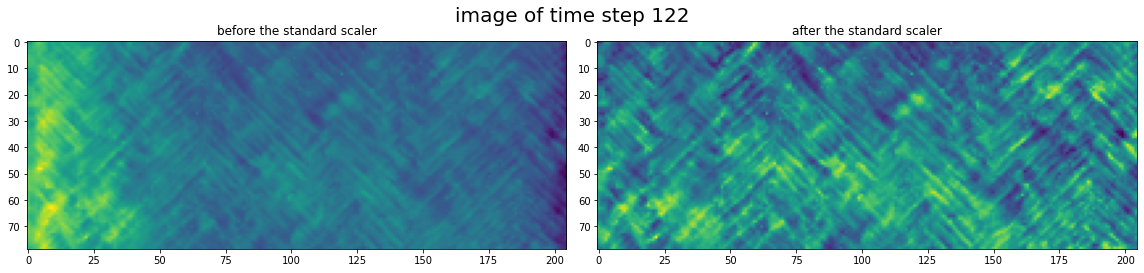

In [ ]:
# show a random image data before and after the transformation 
show_random_example = True
if show_random_example:
  fig,ax = plt.subplots(1,2,figsize=(16,4))
  i = np.random.randint(0,129)
  fig.suptitle('image of time step '+str(i),fontsize = 20)
  ax[0].imshow(input_data[i])
  ax[0].title.set_text('before the standard scaler')
  ax[1].imshow(input_2[i])
  ax[1].title.set_text('after the standard scaler')
  fig.tight_layout()

In [ ]:
# use the window with size 15 by 15 scanning each image (stride=1) to generate the input of the autoencoder model 
input_2[0].shape
data = []
for image in input_2:
    for i in range(79-15):
        for j in range(205-15):
            data.append(image[i:i+15,j:j+15])
data = np.array(data)

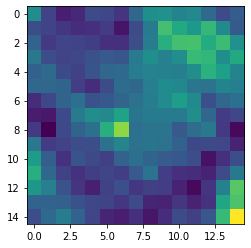

In [ ]:
# show a random example of input data
plt.imshow(data[np.random.randint(data.shape[0])])

# Autoencoder Model


# Conv2D model 

In [ ]:
# Convolutional block which includes the ResNet 
class conv_block(nn.Module):
    def __init__(self,t_size,n_step):
        super(conv_block,self).__init__()
        self.cov1d_1 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov1d_2 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.norm_3 = nn.LayerNorm(n_step)
        self.relu_4 = nn.ReLU()
        
    def forward(self,x):
        x_input = x
        out = self.cov1d_1(x)       
        out = self.cov1d_2(out)
        out = self.norm_3(out) 
        out = self.relu_4(out)
        out = out.add(x_input)
        return out

In [ ]:
# Identity Block which has one convolutional layer inside
class identity_block(nn.Module):
    def __init__(self,t_size,n_step):
        super(identity_block,self).__init__()
        self.cov1d_1 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.norm_1 = nn.LayerNorm(n_step)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        x_input = x
        out = self.cov1d_1(x)
        out = self.norm_1(out)
        out = self.relu(out)
        return out

In [ ]:
# Encoder of the model 
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.cov2d = nn.Conv2d(1,128,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov2d_1 = nn.Conv2d(128,1,3,stride=1,padding=1,padding_mode = 'zeros')
        self.conv_block_1 = conv_block(t_size=128,n_step=[15,15])
        self.conv_block_2 = conv_block(t_size=128,n_step=[15,15])
        self.conv_block_3 = conv_block(t_size=128,n_step=[15,15])
        self.iden_block_1 = identity_block(t_size=128,n_step=[15,15])
        self.iden_block_2 = identity_block(t_size=128,n_step=[15,15])
        self.iden_block_3 = identity_block(t_size=128,n_step=[15,15])
        self.relu_1 = nn.ReLU()
        self.dense = nn.Linear(225,64)

        
    def forward(self,x):
        out = x.view(-1,1,15,15)
        out = self.cov2d(out)
        out = self.iden_block_1(out)
        out = self.conv_block_1(out)
        out = self.iden_block_2(out)
        out = self.conv_block_2(out)
        out = self.iden_block_3(out)
        out = self.conv_block_3(out)
        out = self.cov2d_1(out)
        out = torch.flatten(out,start_dim=1)
        selection = self.dense(out)
        selection = self.relu_1(selection)
        return selection

In [ ]:
# Decoder of the model
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.dense = nn.Linear(64,225)
        self.cov2d = nn.Conv2d(1,128,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov2d_1 = nn.Conv2d(128,1,3,stride=1,padding=1,padding_mode = 'zeros')
        self.conv_block_1 = conv_block(t_size=128,n_step=[15,15])
        self.conv_block_2 = conv_block(t_size=128,n_step=[15,15])
        self.conv_block_3 = conv_block(t_size=128,n_step=[15,15])
        self.iden_block_1 = identity_block(t_size=128,n_step=[15,15])
        self.iden_block_2 = identity_block(t_size=128,n_step=[15,15])
        self.iden_block_3 = identity_block(t_size=128,n_step=[15,15])

        
    def forward(self,x):
        out = self.dense(x)
        out = out.view(-1,1,15,15)
        out = self.cov2d(out)
        out = self.iden_block_1(out)
        out = self.conv_block_1(out)
        out = self.iden_block_2(out)
        out = self.conv_block_2(out)
        out = self.iden_block_3(out)
        out = self.conv_block_3(out)
        out = self.cov2d_1(out)
        out = out.view(-1,15,15)
        return out

In [ ]:
# Generate the autoencoder model structure
class auto(nn.Module):
    
    ''' This is the class that builds the autoencoder from the blocks.

    '''
    def __init__(self, enc, dec):
        super().__init__()
        self.enc = enc
        self.dec = dec

    def forward(self, x):
        # encoder
        embedding = self.enc(x)
        # decode
        predicted = self.dec(embedding)
        return predicted

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Establish the model and the optimizer
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = auto(encoder, decoder).to(device)
# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)

# load  data

In [ ]:
# if we want to retrain the model from the beginning, we set the retrain = True, 
# else we directly use the pretrained the weights to generate the results.
retrain = False
if retrain:
  train_iterator = torch.utils.data.DataLoader(data, batch_size = 512,shuffle = True)

In [ ]:
# define the loss function of the model, the loss function is MSE used to update the gradient.

def loss_function(model,
                  encoder,
                  decoder,
                  train_iterator,
                  optimizer,
                  ):

    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0
    for x in tqdm(train_iterator, leave=True, total=len(train_iterator)):
 
        x = x.to(device, dtype=torch.float)
        # update the gradients to zero
        optimizer.zero_grad()
        embedding = encoder(x)

        predicted_x = decoder(embedding)

        # reconstruction loss
        loss = F.mse_loss(x, predicted_x, reduction='mean')       

        # backward pass
        train_loss += loss.item()
        loss.backward()
        # update the weights
        optimizer.step()

    return train_loss

In [ ]:
# Define the Trian function, to set the one line code for training.
def Train(model,encoder,decoder,train_iterator,optimizer,
          epochs, weights_name = 'generated_weights'):
    """
    model: autoencoder model
    encoder: encoder of the model
    decoder: decoder of the model
    train_iterator: the format of the input data, which is DataLoader in this notebook
    optimizer: optimizer of the model
    epochs: total training epochs
    weights_name: the generated weights name

    """
    N_EPOCHS = epochs
    best_train_loss = float('inf')
    
    for epoch in range(N_EPOCHS):

        train = loss_function(model,encoder,decoder,train_iterator,
                              optimizer)
        train_loss = train
        train_loss /= len(train_iterator)
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}')
        print('.............................')

        if best_train_loss > train_loss:
            best_train_loss = train_loss
            patience_counter = 1
            checkpoint = {
                "net": model.state_dict(),
                'optimizer': optimizer.state_dict(),
                "epoch": epoch,
                "encoder": encoder.state_dict(), 
                'decoder': decoder.state_dict()
            }

            torch.save(checkpoint, f''+weights_name + '.pkl')
            


In [ ]:
# train the model from the very beginning 
if retrain:
  Train(model,encoder,decoder,train_iterator,optimizer,20)

# Load the weights of the trained model

In [ ]:
# load the weights to generate the result.
if retrain:
  path_checkpoint = 'generated_weights.pkl'
else:
  path_checkpoint = "High-Velocity-Low-Voltage-Collective-In-Plane-Switching-in-100-BaTiO3ThinFilms/5.27_pre_l1=0_deep_model.pkl"  
if torch.cuda.is_available():
  checkpoint = torch.load(path_checkpoint) 
else:
  checkpoint = torch.load(path_checkpoint, map_location=torch.device('cpu'))  

model.load_state_dict(checkpoint['net'])
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
optimizer.load_state_dict(checkpoint['optimizer'])  
start_epoch = checkpoint['epoch']  

# Generate the embedding and reconstruction 

In [ ]:
# Put the input data into Dataloader w/o shuffle
train_iterator = torch.utils.data.DataLoader(data,batch_size = 190,shuffle = False)

In [ ]:
# Generate the result of the embedding and reconstruction
result_ = np.zeros([1568640,64])
recon = np.zeros([1568640,15,15])
for i, x in enumerate(tqdm(train_iterator)):
    with torch.no_grad():
        value = x
        if torch.cuda.is_available():
          test_value = Variable(value.cuda())
        else:
          test_value = Variable(value)
        test_value = test_value.float()
        result = model(test_value)
        result1 = result.cpu()
        embedding = encoder(test_value)
        embedding1 = embedding.to('cpu')
        result1 = result1.detach().numpy()
        embedding1 = embedding1.detach().numpy()
        embedding1 = embedding1.reshape(190,64)
        result_[i*190:(i+1)*190,:] = embedding1
        recon[i*190:(i+1)*190,:,:] = result1        

100%|██████████| 8256/8256 [05:52<00:00, 23.42it/s]


# Generate the activated embedding channel

In [ ]:
# load the voltage change according to the time step.
CV = np.load('CV.CV',allow_pickle=True)
CV['V'].shape

(129,)

In [ ]:
# Generate the folder to save the figures.
os.makedirs('save_figure', exist_ok=True)

In [ ]:
# Show the index of the activated channel and the first image of each activated channel's embedding. 
activated_channel_shown = False
if activated_channel_shown:
  j=0
  list_new = []
  for i in range(64):
      plt.figure(figsize=(10,10))
      if np.sum(result_[:,i]>0):
          j+=1
          print('channel '+ str(i)+ ' is activated')
          list_new.append(i)
          plt.title(str(i))
          plt.imshow(result_[:,i].reshape(129,64,190)[0])
  print('The number of activated channels is '+ str(j))

# generate the binary changing movie

In [ ]:
# Reshape the embedding among (time step, width of the image, length of the image, channel)
result_com = result_[:,].reshape(129,64,190,64)

In [ ]:
# Define the function: find the time step with largest pixel change between time step i and time step j.
def find_largest_time_step(images,start,end,i,j):
    times = start
    record = times
    error = 0
    while(times<end):
        test_error = np.sum(abs(images[times+1,i,j]-images[times,i,j]))
        if test_error>error:
            record = times+1
            error = test_error
        times+=1
    
    return record

In [ ]:
# initial the movie with all the pixel = 0 among all time steps
modified_movie = np.zeros([129,64,190])

In [ ]:
# For each pixel, find the largest value change of the time step in different time period, 
# and shift the value of that index between 0 and 1 to generate the binary movie.
for i in range(64):
    for j in range(190):

        f_1 = find_largest_time_step(result_com,0,16,i,j)
        s_2 = find_largest_time_step(result_com,16,48,i,j)
        t_3 = find_largest_time_step(result_com,48,80,i,j)
        f_4 = find_largest_time_step(result_com,80,112,i,j)

        modified_movie[f_1:s_2,i,j] = 1
        modified_movie[s_2:t_3,i,j] = 0
        modified_movie[t_3:f_4,i,j] = 1
        

Text(0, 0.5, 'Switched Pixels')

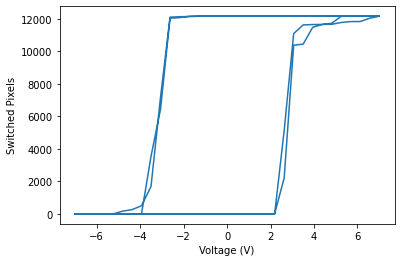

In [ ]:
# check the value change for each time step
plt.plot(CV['V'], np.sum(modified_movie.reshape(129,-1),axis=1))
plt.xlabel('Voltage (V)')
plt.ylabel('Switched Pixels')

In [ ]:
# define the make folder function to generate new folder 
def make_folder(folder, **kwargs):
    """
    Function that makes new folders
    Parameters
    ----------'
    folder : string
        folder where to save
    Returns
    -------
    folder : string
        folder where to save
    """

    # Makes folder
    os.makedirs(folder, exist_ok=True)

    return (folder)

# define the make_movie_1 function to generate the binary movie.
def make_movie(movie_name, input_folder, output_folder, file_format,
                            fps, output_format = 'mp4', reverse = False):

    """
    Function which makes movies from an image series

    Parameters
    ----------
    movie_name : string
        name of the movie
    input_folder  : string
        folder where the image series is located
    output_folder  : string
        folder where the movie will be saved
    file_format  : string
        sets the format of the files to import
    fps  : numpy, int
        frames per second
    output_format  : string, optional
        sets the format for the output file
        supported types .mp4 and gif
        animated gif create large files
    reverse : bool, optional
        sets if the movie will be one way of there and back
    """

    # searches the folder and finds the files
    file_list = glob.glob('./' + input_folder + '/*.' + file_format)
#     print(input_folder)
#     print(file_list)

    # Sorts the files by number makes 2 lists to go forward and back
    list.sort(file_list)
    file_list_rev = glob.glob('./' + input_folder + '/*.' + file_format)
    list.sort(file_list_rev,reverse=True)

    # combines the file list if including the reverse
    if reverse:
        new_list = file_list + file_list_rev
    else:
        new_list = file_list
#        print(new_list)


    if output_format == 'gif':
        # makes an animated gif from the images
        clip = ImageSequenceClip(new_list, fps=fps)
        clip.write_gif(output_folder + '/{}.gif'.format(movie_name), fps=fps)
    else:
        
        # makes and mp4 from the images
        clip = ImageSequenceClip(new_list, fps=fps)
        clip.write_videofile(output_folder + '/{}.mp4'.format(movie_name), fps=fps)

In [ ]:
# Generate the binary shift change image for each time step into particular folder
new_folder = make_folder('binary_movie_com_l1=0_deep_model')
for i in range(129):
    fig=plt.figure(figsize=(16,4))
    axes=fig.subplots(1,2,gridspec_kw={'width_ratios': [8, 2]})
    axes[0].imshow(modified_movie[i],vmin=0,vmax=1)
    axes[1].plot(CV['V'],CV['C']*1E10,color=[0,0,0],lw=0.2)
    CVi=i
    axes[1].plot(CV['V'][CVi],CV['C'][CVi]*1E10,'o',color=[1,0,0],fillstyle='none')
    if i<10:
        num=str('00')+str(i)
    elif i<100:
        num=str('0')+str(i)
    else:
        num=str(i)
    fig.savefig(new_folder+'/'+num+'_.png')
    plt.close(fig)

In [ ]:
# generate the movie in the same folder
folders=new_folder
make_movie('binary_movie_com',
           folders,
           'save_figure',
          'png',
          3)

[MoviePy] >>>> Building video save_figure/binary_movie_com.mp4
[MoviePy] Writing video save_figure/binary_movie_com.mp4


100%|██████████| 130/130 [00:02<00:00, 49.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: save_figure/binary_movie_com.mp4 



In [ ]:
# play the movie
Video("save_figure/binary_movie_com.mp4", embed=True)

# find the shifted area for the 5th and 6th time step

## make the input data to be the comparasion

In [ ]:
# Reshape the input data for comparsion
ori_data = data.reshape(129,64,190,15,15)

In [ ]:
# Extract the original data in time step 5 and 6
ori_input_5 = ori_data[5]
ori_input_6 = ori_data[6]

In [ ]:
# extract the index of the pixel changed between time step 5 and 6
area_5 = (modified_movie[5]==0)
area_6 = (modified_movie[6]==0)
shifted = area_6 !=area_5

In [ ]:
# initial the value = 0 for binary image at time step 5, 6 and shift image 
zeros_5 = np.zeros([64,190])+1
zeros_6 = np.zeros([64,190])+1
zeros_c = np.zeros([64,190])

In [ ]:
# Set the place where shift happened equal to 0
zeros_5[area_5]=0
zeros_6[area_6]=0
zeros_c[shifted]=1

In [ ]:
# set the image shape 
zeros_ = np.zeros([64,190])

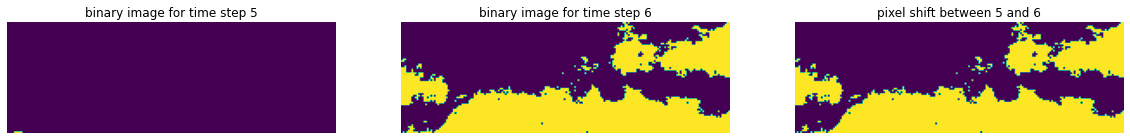

In [ ]:
# generate the binary image of time step 5,6 and pixel shift, then save it to the save figure folder
fig,ax = plt.subplots(1,3,figsize=(20,10))
ax[0].title.set_text('binary image for time step 5')
ax[0].imshow(zeros_5)
ax[1].title.set_text('binary image for time step 6')
ax[1].imshow(zeros_6)
ax[2].title.set_text('pixel shift between 5 and 6')
ax[2].imshow(zeros_c)
for i in range(3):
    ax[i].set_axis_off()
fig.savefig('save_figure/visualize_shift_for_5&6.png')

# reshape the embedding out

In [ ]:
# Reshape the embedding 
gen_part = result_.reshape(129,64,190,64)

# pick the 5th and 6th time step as generator input across all the embedding channels

In [ ]:
input_5 = gen_part[5]
input_6 = gen_part[6]

# pick the different value area in input_5 and input_6

In [ ]:
# Extract the position where shift happend between time step 5 and 6 according to the binary image for embedding out of time step 5 and 6
input_5 = input_5[shifted]
input_6 = input_6[shifted]

In [ ]:
# Extract the position where shift happend between time step 5 and 6 according to the binary image for input image of time step 5 and 6
ori_input_5 = ori_input_5[shifted]
ori_input_6 = ori_input_6[shifted]

In [ ]:
# Move the decoder to cpu for prediction
decoder.to('cpu')

Decoder(
  (dense): Linear(in_features=64, out_features=225, bias=True)
  (cov2d): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cov2d_1): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_block_1): conv_block(
    (cov1d_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (cov1d_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm_3): LayerNorm((15, 15), eps=1e-05, elementwise_affine=True)
    (relu_4): ReLU()
  )
  (conv_block_2): conv_block(
    (cov1d_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (cov1d_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm_3): LayerNorm((15, 15), eps=1e-05, elementwise_affine=True)
    (relu_4): ReLU()
  )
  (conv_block_3): conv_block(
    (cov1d_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (cov1d_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1

# put the data into tensor format then do the decoder

# find the index of medium difference between 5th and 6th time step

In [ ]:
# find the index of medium difference between 5th and 6th time step
a = np.abs(np.mean(input_6-input_5,axis=1))
# show the index of the medium shfited pixel
np.argsort(a)[a.shape[0]//2]

778

In [ ]:
# sort the shift positon 
np.argsort(a)

array([4615, 4308, 3225, ..., 1408, 1427, 1428])

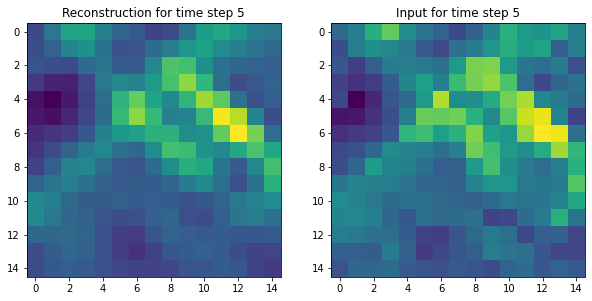

In [ ]:
# Generate and compare the original data and reconstruction data in time step 5 at medium difference shift pixel of embedding.
ii=778
input_5_t = torch.tensor(input_5[ii],dtype=torch.float)
out_5 = decoder(input_5_t)
ot_5 = out_5.detach().cpu().numpy()
fig,ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(ot_5.reshape(15,15))
ax[0].title.set_text('Reconstruction for time step 5')
ax[1].imshow(ori_input_5[ii])
ax[1].title.set_text('Input for time step 5')
fig.savefig('save_figure/Input_recon_compare_time-step-5.eps')

In [ ]:
CV['V'][7]

3.0646875

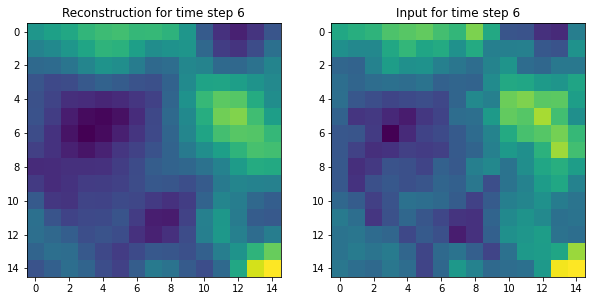

In [ ]:
# Generate and compare the original data and reconstruction data in time step 6 at medium difference shift pixel of embedding.
jj=778
input_6_t = torch.tensor(input_6[jj],dtype=torch.float)
out_6 = decoder(input_6_t)
ot_6 = out_6.detach().cpu().numpy()
fig,ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(ot_6.reshape(15,15))
ax[0].title.set_text('Reconstruction for time step 6')
ax[1].imshow(ori_input_6[jj])
ax[1].title.set_text('Input for time step 6')
fig.savefig('save_figure/Input_recon_compare_time-step-6.eps')

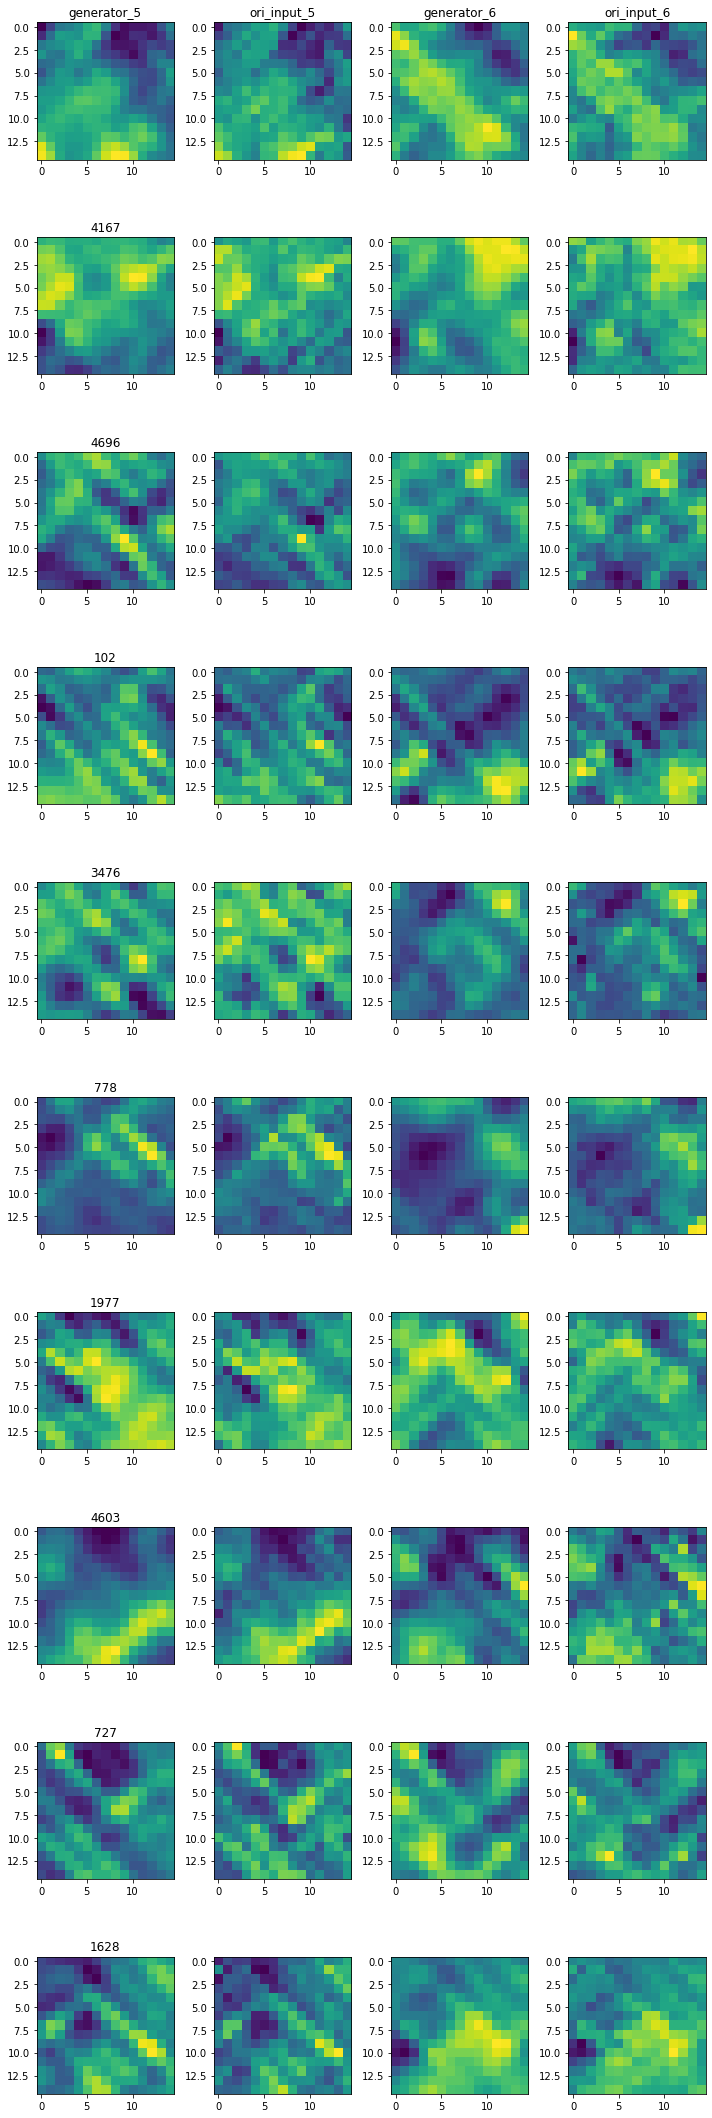

In [ ]:
# Extract the medium 10 shifted positon for comparison between time step 5 and 6 
k = np.argsort(a)[a.shape[0]//2-5:a.shape[0]//2+5]
input_5_k = torch.tensor(input_5,dtype=torch.float)
input_6_k = torch.tensor(input_6,dtype=torch.float)
fig, axs = plt.subplots(10, 4, figsize=(10, 30))
axs.reshape(-1)
m=0
for i in range (0,10):
        out_k_5 = decoder(input_5_k[k[m]])
        out_k_6 = decoder(input_6_k[k[m]])
        ot_5 = out_k_5.detach().cpu().numpy()
        ot_6 = out_k_6.detach().cpu().numpy()
        ax = axs[i,0]
        ax1 = axs[i,1]
        ax.set_title(str(k[m]))
        ax2 = axs[i,2]
        ax3 = axs[i,3]
        if i==0:
            ax.set_title('generator_5')
            ax1.set_title('ori_input_5')
            ax2.set_title('generator_6')
            ax3.set_title('ori_input_6')
        ax.imshow(ot_5.reshape(15,15))
        ax1.imshow(ori_input_5[k[m]])
        ax2.imshow(ot_6.reshape(15,15))
        ax3.imshow(ori_input_6[k[m]])
        m=m+1
fig.tight_layout()
fig.savefig('save_figure/10_medium_shifted_area.png')